In [525]:
import torch
from torch.utils.data import Dataset
import cv2
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
import math
import os
from datetime import datetime
from time import strftime
import csv
import numpy as np
import unet
import unet2
import unet3

# Implementation

In [526]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.imagePaths[idx]
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], 0)
        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
            mask = (mask > 0.5)*1.
        # return a tuple of the image and its mask
        return (image, mask)

In [527]:
def save_training_dataset(path, trainDs, testDs, valDs):
    # train
    trainPath = os.path.join(path, 'train.csv')
    with open(trainPath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for i in range(len(trainDs)):
            writer.writerow([trainDs.imagePaths[i], trainDs.maskPaths[i]])

    # test
    trainPath = os.path.join(path, 'test.csv')
    with open(trainPath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for i in range(len(testDs)):
            writer.writerow([testDs.imagePaths[i], testDs.maskPaths[i]])
        
    # val
    trainPath = os.path.join(path, 'val.csv')
    with open(trainPath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for i in range(len(valDs)):
            writer.writerow([valDs.imagePaths[i], valDs.maskPaths[i]])

In [528]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 

device = torch.device(dev)


In [529]:
def train_test_val_split(imagePath, maskPath):
    # Loading images
    baseImages = os.listdir(imagePath)
    baseMasks = os.listdir(maskPath)
    images = [os.path.join(imagePath, image) for image in baseImages]
    masks = [os.path.join(maskPath, mask) for mask in baseMasks]

#     images = images[:100]
    split = [0.8, 0.1, 0.1]
    splitLength = [math.floor(fraction*len(images)) for fraction in split]
    split = random_split(range(len(images)),splitLength, generator=torch.Generator().manual_seed(8))
    trainImages = [images[i] for i in split[0]]
    trainMasks = [masks[i] for i in split[0]]
    testImages = [images[i] for i in split[1]]
    testMasks = [masks[i] for i in split[1]]
    valImages = [images[i] for i in split[2]]
    valMasks = [masks[i] for i in split[2]]

    trainSize = len(trainImages)
    testSize = len(testImages)
    valSize = len(valImages)

    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128, 128))])
    trainDs = SegmentationDataset(trainImages, trainMasks, transform)
    testDs = SegmentationDataset(testImages, testMasks, transform)
    valDs = SegmentationDataset(valImages, valMasks, transform)
    
    return trainDs, testDs, valDs

In [536]:
def train(model, trainDs, valDs, lossfunc):
    global modelPath
    batchSize = 32
    lr = 0.005
    epochs = 40
    
    path = "./models"
    time = datetime.now().strftime("%H-%M-%S")
    folder = os.path.join(path, time)
    os.mkdir(folder)
    save_training_dataset(folder, trainDs, testDs, valDs)
    print(f'starting training in {folder}')
    modelPath = time
    checkpoint = 5
    
    trainLoader = DataLoader(trainDs, shuffle=True, batch_size=batchSize)
    valLoader = DataLoader(valDs, shuffle=True, batch_size=batchSize)

    opt = Adam(model.parameters(), lr=lr)

    trainLosses = []
    valLosses = []

    for epoch in range(epochs):
        print(f"epoch: {epoch}/{epochs}")
        model.train()
        trainLoss = 0
        valLoss = 0
        trainSteps = 0
        testSteps = 0
        for (x,y) in trainLoader:
            print(f"batch: {trainSteps}/{math.floor(trainSize/batchSize)}")
            trainSteps +=1
            pred = model(x)
            loss = lossFunc(pred, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            trainLoss+=loss
            
        with torch.no_grad():
            model.eval()
            for (x, y) in valLoader:
                testSteps+=1
                pred = model(x)
                valLoss += lossFunc(pred, y)

        trainLosses.append(trainLoss.item()/trainSteps)
        valLosses.append(valLoss.item()/testSteps)
        
        if(epoch%checkpoint == 0):
            torch.save(model, os.path.join(folder, f'epoch-{epoch}.pt'))
    return trainLosses, valLosses

def load_training(path):
    global modelPath
    modelPath = path
    path = os.path.join('./models', modelPath)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128, 128))])
    # train
    train_file = os.path.join(path, 'train.csv')
    trainImages = []
    trainMasks = []
    with open(train_file, newline='') as f:
        reader = csv.reader(f, delimiter=' ')
        for row in reader:
            trainImages.append(row[0])
            trainMasks.append(row[1])
    trainDs = SegmentationDataset(trainImages, trainMasks, transform)
    
    # test
    test_file = os.path.join(path, 'test.csv')
    testImages = []
    testMasks = []
    with open(test_file, newline='') as f:
        reader = csv.reader(f, delimiter=' ')
        for row in reader:
            testImages.append(row[0])
            testMasks.append(row[1])
    testDs = SegmentationDataset(testImages, testMasks, transform)
    
    # val
    val_file = os.path.join(path, 'val.csv')
    valImages = []
    valMasks = []
    with open(val_file, newline='') as f:
        reader = csv.reader(f, delimiter=' ')
        for row in reader:
            valImages.append(row[0])
            valMasks.append(row[1])
    valDs = SegmentationDataset(valImages, valMasks, transform)
    
    modelList = [fileName for fileName in os.listdir(path) if fileName.split('.')[-1] == 'pt']
    epochList = [int(model.split('.')[0].split('-')[-1]) for model in modelList]
    num = max(epochList)
    modelPathSave = os.path.join(path, f'epoch-{num}.pt')
    print(f"loading {modelPathSave}")
    model = torch.load(modelPathSave)
    return trainDs, testDs, valDs, model

In [531]:
def test(model, testDs, lossFunc):
    global modelPath
    model.eval()
    threshold = 0.45
    testLoss = 0
    testSteps = 0
    testLoader = DataLoader(testDs, shuffle=True, batch_size=1)
    finalTP = 0
    finalTN = 0
    finalFP = 0
    finalFN = 0
    with torch.no_grad():
        for (x, y) in testLoader:
            testSteps += 1
            pred = model(x)
            testLoss += lossFunc(pred, y)
            TP, TN, FP, FN = results(y, (pred>threshold)*1)
            finalTP += TP
            finalTN += TN
            finalFP += FP
            finalFN += FN
            
    testLoss /= testSteps
    precision = round(finalTP / (finalTP + finalFP) if (finalTP + finalFP) > 0 else 0, 2)
    recall =  round(finalTP / (finalTP + finalFN) if (finalTP + finalFN) > 0 else 0, 2)
    accuracy = round((finalTN + finalTP) / (finalTP + finalTN + finalFN + finalFP),2)
    f1_score = round(2 * precision * recall / (recall + precision) if (recall + precision) > 0 else 0, 2)
    
    plotConfusion(finalTP, finalTN, finalFP, finalFN, os.path.join('./models', modelPath, 'confusion.png'))
    resultsString = f"loss: {round(testLoss.item(), 2)} precision: {precision}, recall: {recall}, accuracy: {accuracy}, f1 score: {f1_score}"
    print(resultsString)
    with open(os.path.join('./models', modelPath, 'results.txt'), 'w') as f:
        f.write(resultsString)

In [532]:
def results(true_batch, pred_batch):
    TP = int(torch.sum(true_batch*pred_batch).item())
    FP = int(torch.sum((1-true_batch)*pred_batch).item())
    TN = int(torch.sum((1-true_batch)*(1-pred_batch)).item())
    FN = int(torch.sum(true_batch*(1-pred_batch)).item())
    return TP, TN, FP, FN

In [533]:
def predict(model, n, testDs):
    global modelPath
    testLoader = DataLoader(testDs, shuffle=True, batch_size=32)
    i = 0
    threshold = 0.4
    with torch.no_grad():
        for (x, y) in testLoader:
            pred = model(x)
            plt.subplot(n, 4, 4*i+1)
            if(i==0):
                plt.title("image originale")
            plt.imshow(x[0,0])
            plt.axis('off')
            plt.subplot(n, 4, 4*i+2)
            if(i==0):
                plt.title("mask original")
            plt.imshow(y[0, 0])
            plt.axis('off')
            plt.subplot(n, 4, 4*i+3)
            if(i==0):
                plt.title("mask prédit")
            plt.imshow(pred[0, 0])
            plt.axis('off')
            plt.subplot(n, 4, 4*i+4)
            if(i==0):
                plt.title("mask prédit final")
            plt.imshow(pred[0, 0]>threshold)
            plt.axis('off')
            if(i==n-1):
                break
            i+=1
        plt.savefig(os.path.join('./models', modelPath, 'prediction.png'))

In [539]:
def plotConfusion(TP, TN, FP, FN, path):
    confusion = np.array([[TP, FP], [FN, TN]])
    fig, ax = plt.subplots()
    im = ax.imshow(confusion, cmap = "YlGn")

    ax.set_xticks([0,1], labels=["Pos", "Neg"])
    ax.set_yticks([0,1], labels=["Pos", "Neg"])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f"{round(confusion[i, j]/(TP+TN+FP+FN)*100, 1)}%",
                           ha="center", va="center", color="black")
    fig.tight_layout()
    plt.show()
    fig.savefig(path)

# Main program

In [511]:
imagePath = "./data/images"
maskPath = "./data/masks"
modelPath = ""
trainDs, testDs, valDs = train_test_val_split(imagePath, maskPath)
trainSize = len(trainDs)
testSize = len(testDs)
valSize = len(valDs)

In [514]:
model = Unet3()
lossFunc = BCEWithLogitsLoss()
train(model, trainDs, valDs, lossFunc)

starting training in ./models\13-36-42
epoch: 0/40
batch: 0/100
batch: 1/100
batch: 2/100
batch: 3/100
batch: 4/100
batch: 5/100
batch: 6/100
batch: 7/100
batch: 8/100
batch: 9/100
batch: 10/100
batch: 11/100
batch: 12/100
batch: 13/100
batch: 14/100
batch: 15/100
batch: 16/100
batch: 17/100
batch: 18/100
batch: 19/100
batch: 20/100
batch: 21/100
batch: 22/100
batch: 23/100
batch: 24/100
batch: 25/100
batch: 26/100
batch: 27/100
batch: 28/100
batch: 29/100
batch: 30/100
batch: 31/100
batch: 32/100
batch: 33/100
batch: 34/100
batch: 35/100
batch: 36/100
batch: 37/100
batch: 38/100
batch: 39/100
batch: 40/100
batch: 41/100
batch: 42/100
batch: 43/100
batch: 44/100
batch: 45/100
batch: 46/100
batch: 47/100
batch: 48/100
batch: 49/100
batch: 50/100
batch: 51/100
batch: 52/100
batch: 53/100
batch: 54/100
batch: 55/100
batch: 56/100
batch: 57/100
batch: 58/100
batch: 59/100
batch: 60/100
batch: 61/100
batch: 62/100
batch: 63/100
batch: 64/100
batch: 65/100
batch: 66/100
batch: 67/100
batch: 

batch: 82/100
batch: 83/100
batch: 84/100
batch: 85/100
batch: 86/100
batch: 87/100
batch: 88/100
batch: 89/100
batch: 90/100
batch: 91/100
batch: 92/100
batch: 93/100
batch: 94/100
batch: 95/100
batch: 96/100
batch: 97/100
batch: 98/100
batch: 99/100
epoch: 6/40
batch: 0/100
batch: 1/100
batch: 2/100
batch: 3/100
batch: 4/100
batch: 5/100
batch: 6/100
batch: 7/100
batch: 8/100
batch: 9/100
batch: 10/100
batch: 11/100
batch: 12/100
batch: 13/100
batch: 14/100
batch: 15/100
batch: 16/100
batch: 17/100
batch: 18/100
batch: 19/100
batch: 20/100
batch: 21/100
batch: 22/100
batch: 23/100
batch: 24/100
batch: 25/100
batch: 26/100
batch: 27/100
batch: 28/100
batch: 29/100
batch: 30/100
batch: 31/100
batch: 32/100
batch: 33/100
batch: 34/100
batch: 35/100
batch: 36/100
batch: 37/100
batch: 38/100
batch: 39/100
batch: 40/100
batch: 41/100
batch: 42/100
batch: 43/100
batch: 44/100
batch: 45/100
batch: 46/100
batch: 47/100
batch: 48/100
batch: 49/100
batch: 50/100
batch: 51/100
batch: 52/100
batc

batch: 67/100
batch: 68/100
batch: 69/100
batch: 70/100
batch: 71/100
batch: 72/100
batch: 73/100
batch: 74/100
batch: 75/100
batch: 76/100
batch: 77/100
batch: 78/100
batch: 79/100
batch: 80/100
batch: 81/100
batch: 82/100
batch: 83/100
batch: 84/100
batch: 85/100
batch: 86/100
batch: 87/100
batch: 88/100
batch: 89/100
batch: 90/100
batch: 91/100
batch: 92/100
batch: 93/100
batch: 94/100
batch: 95/100
batch: 96/100
batch: 97/100
batch: 98/100
batch: 99/100
epoch: 12/40
batch: 0/100
batch: 1/100
batch: 2/100
batch: 3/100
batch: 4/100
batch: 5/100
batch: 6/100
batch: 7/100
batch: 8/100
batch: 9/100
batch: 10/100
batch: 11/100
batch: 12/100
batch: 13/100
batch: 14/100
batch: 15/100
batch: 16/100
batch: 17/100
batch: 18/100
batch: 19/100
batch: 20/100
batch: 21/100
batch: 22/100
batch: 23/100
batch: 24/100
batch: 25/100
batch: 26/100
batch: 27/100
batch: 28/100
batch: 29/100
batch: 30/100
batch: 31/100
batch: 32/100
batch: 33/100
batch: 34/100
batch: 35/100
batch: 36/100
batch: 37/100
bat

batch: 51/100
batch: 52/100
batch: 53/100
batch: 54/100
batch: 55/100
batch: 56/100
batch: 57/100
batch: 58/100
batch: 59/100
batch: 60/100
batch: 61/100
batch: 62/100
batch: 63/100
batch: 64/100
batch: 65/100
batch: 66/100
batch: 67/100
batch: 68/100
batch: 69/100
batch: 70/100
batch: 71/100
batch: 72/100
batch: 73/100
batch: 74/100
batch: 75/100
batch: 76/100
batch: 77/100
batch: 78/100
batch: 79/100
batch: 80/100
batch: 81/100
batch: 82/100
batch: 83/100
batch: 84/100
batch: 85/100
batch: 86/100
batch: 87/100
batch: 88/100
batch: 89/100
batch: 90/100
batch: 91/100
batch: 92/100
batch: 93/100
batch: 94/100
batch: 95/100
batch: 96/100
batch: 97/100
batch: 98/100
batch: 99/100
epoch: 18/40
batch: 0/100
batch: 1/100
batch: 2/100
batch: 3/100
batch: 4/100
batch: 5/100
batch: 6/100
batch: 7/100
batch: 8/100
batch: 9/100
batch: 10/100
batch: 11/100
batch: 12/100
batch: 13/100
batch: 14/100
batch: 15/100
batch: 16/100
batch: 17/100
batch: 18/100
batch: 19/100
batch: 20/100
batch: 21/100
bat

batch: 35/100
batch: 36/100
batch: 37/100
batch: 38/100
batch: 39/100
batch: 40/100
batch: 41/100
batch: 42/100
batch: 43/100
batch: 44/100
batch: 45/100
batch: 46/100
batch: 47/100
batch: 48/100
batch: 49/100
batch: 50/100
batch: 51/100
batch: 52/100
batch: 53/100
batch: 54/100
batch: 55/100
batch: 56/100
batch: 57/100
batch: 58/100
batch: 59/100
batch: 60/100
batch: 61/100
batch: 62/100
batch: 63/100
batch: 64/100
batch: 65/100
batch: 66/100
batch: 67/100
batch: 68/100
batch: 69/100
batch: 70/100
batch: 71/100
batch: 72/100
batch: 73/100
batch: 74/100
batch: 75/100
batch: 76/100
batch: 77/100
batch: 78/100
batch: 79/100
batch: 80/100
batch: 81/100
batch: 82/100
batch: 83/100
batch: 84/100
batch: 85/100
batch: 86/100
batch: 87/100
batch: 88/100
batch: 89/100
batch: 90/100
batch: 91/100
batch: 92/100
batch: 93/100
batch: 94/100
batch: 95/100
batch: 96/100
batch: 97/100
batch: 98/100
batch: 99/100
epoch: 24/40
batch: 0/100
batch: 1/100
batch: 2/100
batch: 3/100
batch: 4/100
batch: 5/100

batch: 19/100
batch: 20/100
batch: 21/100
batch: 22/100
batch: 23/100
batch: 24/100
batch: 25/100
batch: 26/100
batch: 27/100
batch: 28/100
batch: 29/100
batch: 30/100
batch: 31/100
batch: 32/100
batch: 33/100
batch: 34/100
batch: 35/100
batch: 36/100
batch: 37/100
batch: 38/100
batch: 39/100
batch: 40/100
batch: 41/100
batch: 42/100
batch: 43/100
batch: 44/100
batch: 45/100
batch: 46/100
batch: 47/100
batch: 48/100
batch: 49/100
batch: 50/100
batch: 51/100
batch: 52/100
batch: 53/100
batch: 54/100
batch: 55/100
batch: 56/100
batch: 57/100
batch: 58/100
batch: 59/100
batch: 60/100
batch: 61/100
batch: 62/100
batch: 63/100
batch: 64/100
batch: 65/100
batch: 66/100
batch: 67/100
batch: 68/100
batch: 69/100
batch: 70/100
batch: 71/100
batch: 72/100
batch: 73/100
batch: 74/100
batch: 75/100
batch: 76/100
batch: 77/100
batch: 78/100
batch: 79/100
batch: 80/100
batch: 81/100
batch: 82/100
batch: 83/100
batch: 84/100
batch: 85/100
batch: 86/100
batch: 87/100
batch: 88/100
batch: 89/100
batch:

batch: 3/100
batch: 4/100
batch: 5/100
batch: 6/100
batch: 7/100
batch: 8/100
batch: 9/100
batch: 10/100
batch: 11/100
batch: 12/100
batch: 13/100
batch: 14/100
batch: 15/100
batch: 16/100
batch: 17/100
batch: 18/100
batch: 19/100
batch: 20/100
batch: 21/100
batch: 22/100
batch: 23/100
batch: 24/100
batch: 25/100
batch: 26/100
batch: 27/100
batch: 28/100
batch: 29/100
batch: 30/100
batch: 31/100
batch: 32/100
batch: 33/100
batch: 34/100
batch: 35/100
batch: 36/100
batch: 37/100
batch: 38/100
batch: 39/100
batch: 40/100
batch: 41/100
batch: 42/100
batch: 43/100
batch: 44/100
batch: 45/100
batch: 46/100
batch: 47/100
batch: 48/100
batch: 49/100
batch: 50/100
batch: 51/100
batch: 52/100
batch: 53/100
batch: 54/100
batch: 55/100
batch: 56/100
batch: 57/100
batch: 58/100
batch: 59/100
batch: 60/100
batch: 61/100
batch: 62/100
batch: 63/100
batch: 64/100
batch: 65/100
batch: 66/100
batch: 67/100
batch: 68/100
batch: 69/100
batch: 70/100
batch: 71/100
batch: 72/100
batch: 73/100
batch: 74/100

([0.731865005493164,
  0.6710474395751953,
  0.6616008758544922,
  0.6577075958251953,
  0.6553050994873046,
  0.6538690948486328,
  0.6518126678466797,
  0.6510149383544922,
  0.6503144073486328,
  0.6490107727050781,
  0.6496276092529297,
  0.6477364349365234,
  0.6473844909667968,
  0.6479485321044922,
  0.6478839874267578,
  0.6476435852050781,
  0.6452063751220704,
  0.64782470703125,
  0.6478692626953125,
  0.6457308959960938,
  0.6446952819824219,
  0.6458338928222657,
  0.6455950927734375,
  0.6442195129394531,
  0.644132308959961,
  0.6438772583007812,
  0.6443717193603515,
  0.6438880157470703,
  0.6447241973876953,
  0.6443306732177735,
  0.6447994995117188,
  0.6430519866943359,
  0.6427394104003906,
  0.6434344482421875,
  0.6430415344238282,
  0.6429524230957031,
  0.6429208374023437,
  0.6424726867675781,
  0.641876220703125,
  0.6420151519775391],
 [0.7064689489511343,
  0.6822948455810547,
  0.6878858713003305,
  0.6837632105900691,
  0.671359135554387,
  0.68679340069

In [537]:
modelPath = '13-36-42'
trainDs, testDs, valDs, model = load_training(modelPath)

loading ./models\13-36-42\epoch-35.pt


In [490]:
train(model, trainDs, valDs, lossFunc)

starting training in ./models\13-20-02
epoch: 0/40
batch: 0/100


KeyboardInterrupt: 

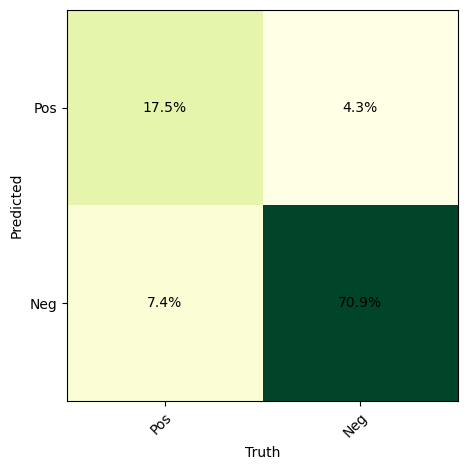

loss: 0.65 precision: 0.8, recall: 0.7, accuracy: 0.88, f1 score: 0.75


In [540]:
test(model, testDs, lossFunc)

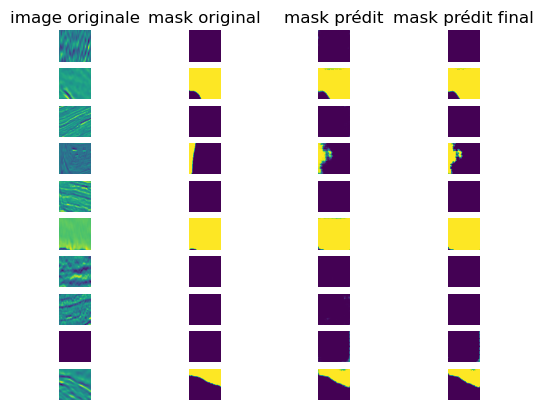

In [541]:
predict(model, 10, testDs)

# Questions

## 1. Max pooling
Technically it is absolutely possible to replace the max pooling with convolutions of stride 2. In practice this will complexify the model and require a longer time to learn since there will be more parameters. Since there will be more parameters, if we have enough data it could increase the performance but also increase overfitting at the same time

## 2. Skip connections
In this architecture skip connections are important to retrieve past lost information during max pooling. It allows to retain details of the picture that can be destroyed when reducing the size of the channels.   
If we remove these skip connections we might not be able to have a detailed image in output that fits the current input because when reducing the dimension we average in a sense around patches of pixels of the image so any sharp variation of the picture would be smoothened by the convolutions.  
It would totally be possible to change the way we add skip connection by adding it to the current output or using a min max procedure. Intuitively the important part is the keep these skip connection to rememeber the different stages of the output. Changing these skip connection could improve performance.

##  3. FCN and Auto-encoder
This architecture of auto-encoder is one of many type and not necessary in a sens that we can always construct a model that given an image outputs an image of same size without making use of auto-encoders. During convolutions it is possible to use parameters such that the image size stays the same, for instance with a kernel of 4 and a padding of 2 the image size doesn't change. In practice the auto-encoder architecture is one that gives satisfying results that we can intuitively explain by the fact that the image is reduced to its core features during the encoding so we can catch a global vision of the image.

## 4. Threshold for inference
In our case we used a threshold to compute true and false negatives and positives. However, here we can defind precision and recall with respect to the "distance" to the true mask, for exemple TP could be the sum over each pixel true_mask[i,j] x predicted_mask[i,j] so that if true mask is 1 predicted_mask should be as close to 1 as possible to maximize the sum. Same for TN, FP and FN and then we could compute precision and recall from these.

In [515]:
modelPath

'13-36-42'

In [483]:
os.path.join("a", "b", "c")

'a\\b\\c'